In [56]:
import tensorflow as tf               # TesorFlow
import numpy as np                    # NumPy
import matplotlib.pyplot as plt       # Графики-то строить будем
import pandas as pd                   # Для работы с таблицами и CSV-файлами
import sklearn.metrics                # Для построения confusion matrix
import seaborn as sns                 # Для отображения confusion matrix
import os                             # Для возможности выбора GPU

In [100]:
# Используем GPU 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Отключаем отладочные сообщения в TensorFlow
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [102]:
#выполнять команды с помощьюб "!"
!nvidia-smi #загруженность gpu

Fri Nov  4 17:10:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0  On |                  N/A |
|  0%    4C    P8     8W / 250W |  10928MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:03:00.0  On |                  N/A |
| 23%   

In [87]:
DATASET_DIR = '/opt/datasets/CIFAR-10'
DATASET_FILE = 'CIFAR-10.csv'

In [88]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 64

In [92]:
#читаем .csv файл, с разделителем - табуляция, а имя файла складываем из констант 
df = pd.read_csv(DATASET_DIR + '/' + DATASET_FILE, sep="\t")
df

,filename,class
0,test/dog/0838.png,dog
1,test/dog/0799.png,dog
2,test/dog/0392.png,dog
3,test/dog/0836.png,dog
4,test/dog/0865.png,dog
...,...,...
59995,train/frog/3491.png,frog
59996,train/frog/2639.png,frog
59997,train/frog/1536.png,frog
59998,train/frog/4391.png,frog


In [93]:
def process_func(x):
    x = DATASET_DIR + '/' + x
    return x

In [94]:
# применяем к каждому элементу столбца функцию process_func, которая добавляет константу, делая путь абсолютным
df['filename'] = df['filename'].apply(process_func)
# дропаем все NaN - not a number - по столбцам, указанным в сабсете; 
# дропаем any - если в хотя бы в одном из столбцов сабсета; 
# inplace = true - значит меняем сам датасет, а не создаём его копию
df.dropna(subset = ['filename', 'class'], how="any", inplace = True) 
df

,filename,class
0,/opt/datasets/CIFAR-10/test/dog/0838.png,dog
1,/opt/datasets/CIFAR-10/test/dog/0799.png,dog
2,/opt/datasets/CIFAR-10/test/dog/0392.png,dog
3,/opt/datasets/CIFAR-10/test/dog/0836.png,dog
4,/opt/datasets/CIFAR-10/test/dog/0865.png,dog
...,...,...
59995,/opt/datasets/CIFAR-10/train/frog/3491.png,frog
59996,/opt/datasets/CIFAR-10/train/frog/2639.png,frog
59997,/opt/datasets/CIFAR-10/train/frog/1536.png,frog
59998,/opt/datasets/CIFAR-10/train/frog/4391.png,frog


<AxesSubplot:>

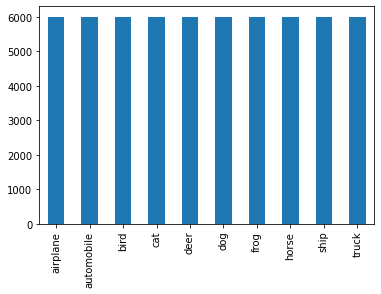

In [95]:
#берём дф столбец класс - считаем количество уникальных значений - сортируем - ploting вида bar 
df['class'].value_counts().sort_index().plot(kind='bar')

In [117]:
# data_format и preprocessing_function берём из хелпа сетки
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    data_format = "channels_last",                                            #ибо сетка была обучена данных в таком формате
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input, #ибо в сетке такая функия и использовалась
    validation_split = 0.1,                                                   #сколько процентов (в десятых) отдаётся под validation
)

# берём данные из датафрейма

# общие аргументы для последующих функций
gen_args = {
    'dataframe': df,
    'x_col': 'filename',
    'y_col': 'class',
    'target_size': IMG_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
}

train_gen = gen.flow_from_dataframe(subset='training', shuffle=True, **gen_args)
val_gen = gen.flow_from_dataframe(subset='validation', shuffle=False, **gen_args)

Found 54000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [123]:
# Получаем из генератора все классы(категории). Берём только values из train_gen.class_indices
classes = list(train_gen.class_indices.values()) 
# Получаем веса классов для уравновешивания датасета
# ground truths берем из генератора (classes)
class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes = classes, y = train_gen.classes)
# Нам вернулся массив весов классов, а нам нужен dict, где ключи - индексы классов, а значения - веса
class_weights = dict(zip(classes, class_weights))                                                                     #совмещаем всё в одну dict 

class_weights

{0: 1.08,
 1: 0.9,
 2: 1.08,
 3: 0.9,
 4: 0.9,
 5: 1.08,
 6: 0.9,
 7: 1.08,
 8: 1.08,
 9: 1.08}

In [140]:
# Определяем callback-функцию, которая сохраняет сеть каждую эпоху, чтобы можно было вернуться к любой точке

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'models/transfer-learning-e{epoch:02d}.h5', #куда сохраняем, здесь параметр epoch, который определяет номер эпохи
    verbose = 1,                                           #даёт ли она комментарий когда она сохраняет
    save_weights_only = False,                             #сохраняем всю модель
    mode = 'auto',
    save_freq = 'epoch',                                   #как часто сохраняем
)

In [6]:
# Берём за основу сеть ResNet50, выбрав её с https://keras.io/api/applications/ и заглянув в хелп по ней https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

backbone_model = tf.keras.applications.resnet50.ResNet50(
    include_top = False,           #не подключаем слой классификации 
    weights = 'imagenet',          #берём предобученные веса
    input_shape = IMG_SIZE + (3,), #определяем input_shape как (высота, ширина, цвета), для этого берем первые 2 параметра из IMG_SIZE и добавляем про цвета
    pooling = None,                #полинга не будет, добавим потом слой распрямления
)

94781440/94765736 [==============================] - 10s 0us/step


In [145]:
# Замараживаем обучение в бэкбоне

for layer in backbone_model.layers:
    layer.training = False
    layer.trainable = False

In [8]:
model = tf.keras.Sequential(name = 'transfer_learning')

model.add(backbone_model)                                 #добавляем бэкбон как обычный слой
model.add(tf.keras.layers.Flatten())                      #слой распрямляния
#model.add(tf.keras.layers.Dense(20, activation='relu'))  #на случай если нужно больше мозгов
model.add(tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax'))#слой классификации, активация ОБЯЗАТЕЛЬНО softmax, количество нейронов = количеству классов, взятому из генератора

model.summary()

Model: "transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),           #в задачах классификации используем losses.CategoricalCrossentropy
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), #учим классификатор, поэтому стандартный learning_rate
    metrics = ['accuracy'],
)

In [10]:
#в этих массивах накапливаем статистику обучений, которое можно запускать несколько раз не теряя статистику

loss = [None]
val_loss = [None]
accuracy = [None]
val_accuracy = [None]
runs = []

In [11]:
EPOCHES = 5

res = model.fit(
    x = train_gen,                           #работаем с генераторами, которые выдают сразу и x(входные данные), и y(ground truth, правильные ответы), поэтому параметр y не используется 
    validation_data = val_gen,
    batch_size = BATCH_SIZE,
    class_weight = class_weights,
    epochs = max(runs, default=0) + EPOCHES, #устанавливаем эпоху для окончания обучения = эпоха из статистики + EPOCHES
    initial_epoch = max(runs, default=0),    #задаём начальную эпоху из статистики
    callbacks = [checkpoint],
)

#добавляем в массивы статистику по текущему обучению
loss += res.history['loss']
val_loss += res.history['val_loss']
accuracy += res.history['accuracy']
val_accuracy += res.history['val_accuracy']
runs += [max(runs, default=0) + len(res.history['loss'])]

Epoch 1/5
782/782 [==============================] - 29s 30ms/step - loss: 1.4909 - accuracy: 0.5753 - val_loss: 1.2703 - val_accuracy: 0.6151
Epoch 2/5
782/782 [==============================] - 22s 28ms/step - loss: 1.1122 - accuracy: 0.6498 - val_loss: 1.2371 - val_accuracy: 0.6249
Epoch 3/5
782/782 [==============================] - 22s 27ms/step - loss: 1.0318 - accuracy: 0.6709 - val_loss: 1.2514 - val_accuracy: 0.6338
Epoch 4/5
782/782 [==============================] - 22s 28ms/step - loss: 1.0026 - accuracy: 0.6807 - val_loss: 1.2831 - val_accuracy: 0.6270
Epoch 5/5
782/782 [==============================] - 22s 28ms/step - loss: 0.9754 - accuracy: 0.6867 - val_loss: 1.2803 - val_accuracy: 0.6350


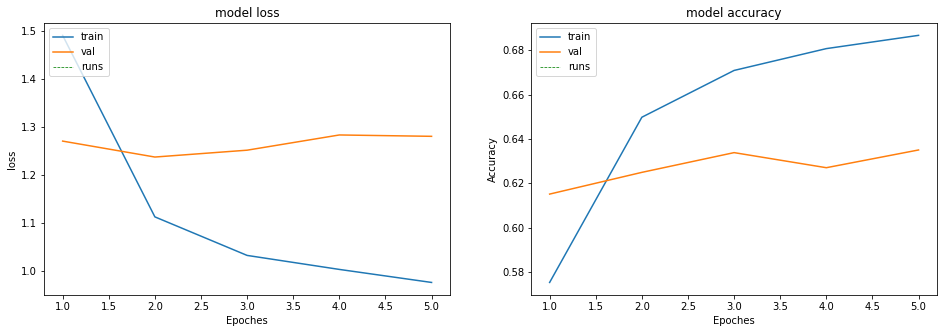

In [12]:
fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(loss)
ax.plot(val_loss)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(accuracy)
ax.plot(val_accuracy)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

In [ ]:
class_names = list(val_gen.class_indices.keys())  #получаем названия классов генератора val_gen

y_pred = model.predict(val_gen)                   #делаем предсказание из val_gen

y_val_pred_class = [np.argmax(i) for i in y_pred] #идём по всем предсказаниям, в каждом предсказании находим номер максимального элемента (максимальной вероятности) 
y_val_true_class = list(val_gen.classes)          #получаем из генератора val_gen правильные ответы (ground truth)

cm = sklearn.metrics.confusion_matrix(
    y_true = y_val_true_class,
    y_pred = y_val_pred_class,
)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #приводим все значения confusion matrix к процентам

plt.figure(figsize=(10,8)) 

#красиво рисуем confusion matrix указывая по осям x и y названия классов

ax = sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues', square=True, linewidths=0.5, linecolor='gray') 
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predict')
ax.set_ylabel('Actual');
plt.show()

## Fine Tuning

In [13]:
# Размораживаем сеть после обучения классификатора 

backbone_model.trainable = True
model.summary()

Model: "transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), #учим размороженную сеть, поэтому низкий learning_rate
    metrics = ['accuracy'],
)

In [19]:
EPOCHES = 2

res = model.fit(
    x = train_gen,                           #работаем с генераторами, которые выдают сразу и x(входные данные), и y(ground truth, правильные ответы), поэтому параметр y не используется
    validation_data = val_gen,
    batch_size = BATCH_SIZE,
    class_weight = class_weights,
    epochs = max(runs, default=0) + EPOCHES, #устанавливаем эпоху для окончания обучения = эпоха из статистики + EPOCHES
    initial_epoch = max(runs, default=0),    #задаём начальную эпоху из статистики
    callbacks = [checkpoint],
)

#добавляем в массивы статистику по текущему обучению
loss += res.history['loss']
val_loss += res.history['val_loss']
accuracy += res.history['accuracy']
val_accuracy += res.history['val_accuracy']
runs += [max(runs, default=0) + len(res.history['loss'])]

Epoch 16/17
782/782 [==============================] - 32s 41ms/step - loss: 0.2633 - accuracy: 0.9136 - val_loss: 0.9684 - val_accuracy: 0.7163
Epoch 17/17
782/782 [==============================] - 32s 41ms/step - loss: 0.2208 - accuracy: 0.9284 - val_loss: 0.9624 - val_accuracy: 0.7254


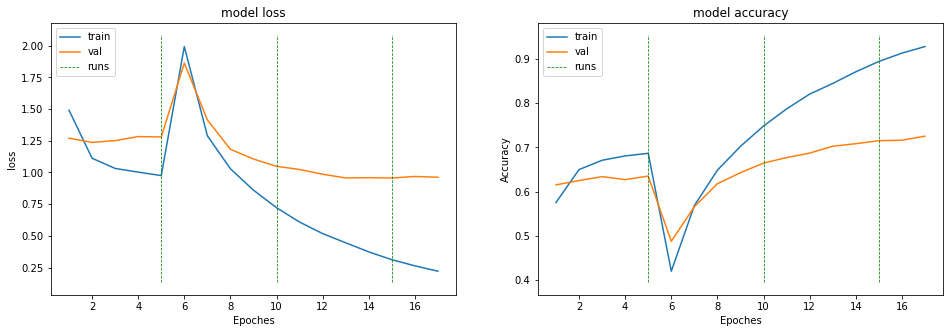

In [20]:
fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(loss)
ax.plot(val_loss)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(accuracy)
ax.plot(val_accuracy)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoches')
ax.legend(['train', 'val', 'runs'], loc='upper left')

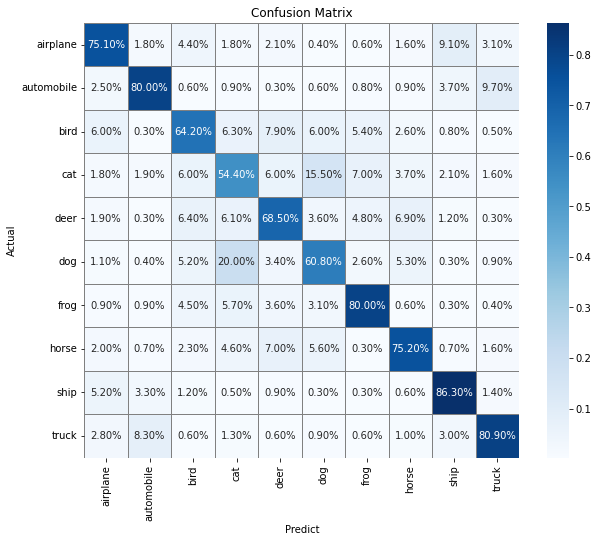

In [25]:
class_names = list(val_gen.class_indices.keys())

y_pred = model.predict(val_gen)

y_val_pred_class = [np.argmax(i) for i in y_pred]
y_val_true_class = list(val_gen.classes)

cm = sklearn.metrics.confusion_matrix(
    y_true = y_val_true_class,
    y_pred = y_val_pred_class,
)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
ax = sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues', square=True, linewidths=0.5, linecolor='gray')
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predict')
ax.set_ylabel('Actual');
plt.show()

In [165]:
# Создаем функцию для простоты inference

from PIL import Image, ImageOps
def get_img_object_name(filename):
    # Читаем файл
    img = Image.open(filename)
    # Ресайзим изображение до размера с которым умеет работать сеть
    img = img.resize(IMG_SIZE)
    img = img.convert('RGB')
    # Представляем изображение как массив NumPy
    data = np.asarray(img)
    # Обрабатываем данные функцией препроцесса, от сети бэкбон
    data = tf.keras.applications.resnet50.preprocess_input(data)
    # Inference модель, предварительно добавив измерение для batch-ей
    data_pred = model.predict(data[np.newaxis, ...])
    # Нам вернулся batch из одного элемента в котороым массив вероятности каждого класса
    # Выбираем класс (точнее его номер) с максимальной вероятностью из нулевого элемента batch-а
    a = np.argmax(data_pred[0])
    # Получаем из генератора список классов
    classes = list(train_gen.class_indices.keys())
    # Из списка слкассов выбираем нужный
    b = classes[a]
    return b

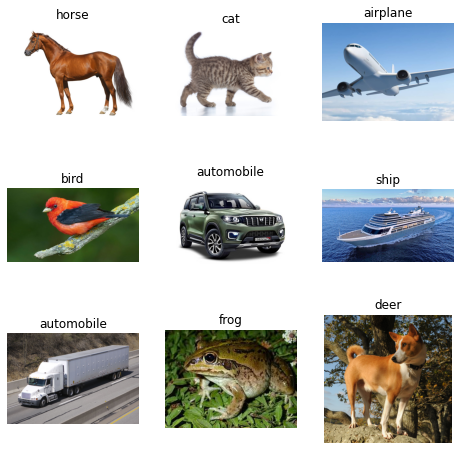

In [148]:
from PIL import Image
import glob

files = glob.glob("/opt/datasets/CIFAR-10/examination/*.jpg")

fig, axs = plt.subplots(3, 3, figsize = (8, 8))
for (fn, ax) in zip(files, axs.flatten()):
    img = Image.open(fn)
    ax.imshow(img)
    ax.set_title(get_img_object_name(fn))
    ax.axis('off')

In [152]:
df_sub = pd.read_csv('07-CIFAR-Example.csv', sep="\t")
df_sub

,filename,object
0,/opt/datasets/CIFAR-10/examination/horse.jpg,NaN
1,/opt/datasets/CIFAR-10/examination/cat.jpg,NaN
2,/opt/datasets/CIFAR-10/examination/airplane.jpg,NaN
3,/opt/datasets/CIFAR-10/examination/bird.jpg,NaN
4,/opt/datasets/CIFAR-10/examination/automobile.jpg,NaN
5,/opt/datasets/CIFAR-10/examination/ship.jpg,NaN
6,/opt/datasets/CIFAR-10/examination/truck.jpg,NaN
7,/opt/datasets/CIFAR-10/examination/frog.jpg,NaN
8,/opt/datasets/CIFAR-10/examination/dog.jpg,NaN


In [154]:
test_files = list(df_sub['filename'])
test_files

['/opt/datasets/CIFAR-10/examination/horse.jpg',
 '/opt/datasets/CIFAR-10/examination/cat.jpg',
 '/opt/datasets/CIFAR-10/examination/airplane.jpg',
 '/opt/datasets/CIFAR-10/examination/bird.jpg',
 '/opt/datasets/CIFAR-10/examination/automobile.jpg',
 '/opt/datasets/CIFAR-10/examination/ship.jpg',
 '/opt/datasets/CIFAR-10/examination/truck.jpg',
 '/opt/datasets/CIFAR-10/examination/frog.jpg',
 '/opt/datasets/CIFAR-10/examination/dog.jpg']

In [157]:
answers = []
for fn in test_files:
    answer = get_img_object_name(fn)
    answers.append(answer)
    
answers

['horse',
 'cat',
 'airplane',
 'bird',
 'automobile',
 'ship',
 'automobile',
 'frog',
 'deer']

In [159]:
df_sub['object'] = answers
df_sub

,filename,object
0,/opt/datasets/CIFAR-10/examination/horse.jpg,horse
1,/opt/datasets/CIFAR-10/examination/cat.jpg,cat
2,/opt/datasets/CIFAR-10/examination/airplane.jpg,airplane
3,/opt/datasets/CIFAR-10/examination/bird.jpg,bird
4,/opt/datasets/CIFAR-10/examination/automobile.jpg,automobile
5,/opt/datasets/CIFAR-10/examination/ship.jpg,ship
6,/opt/datasets/CIFAR-10/examination/truck.jpg,automobile
7,/opt/datasets/CIFAR-10/examination/frog.jpg,frog
8,/opt/datasets/CIFAR-10/examination/dog.jpg,deer


In [160]:
df_sub.to_csv('07-CIFAR-submission.csv', sep="\t")